In [69]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

#  Beatles 사진으로 human_segmentation 해보며 문제점 찾기 

(976, 976, 3)


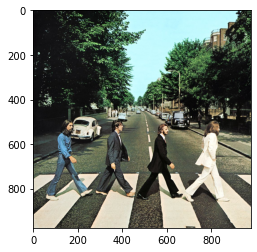

In [24]:
img_path = 'TheBeatles.jpg'  
img_orig = cv2.imread(img_path) 

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [25]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ff71d769f40>)

In [26]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [27]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [28]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

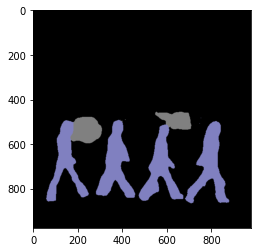

In [29]:
plt.imshow(output)
plt.show()

In [31]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
car
person


In [32]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [33]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

In [34]:
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(976, 976)


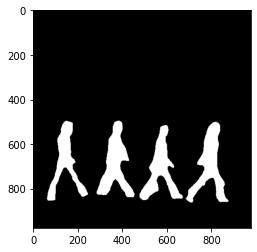

In [35]:
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

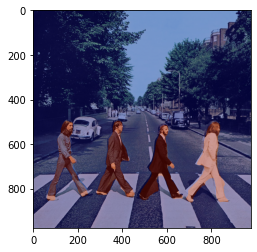

In [36]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

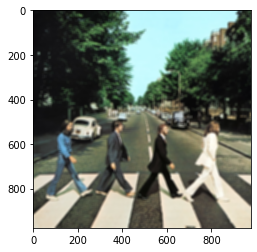

In [37]:
img_orig_blur = cv2.blur(img_orig, (13,13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

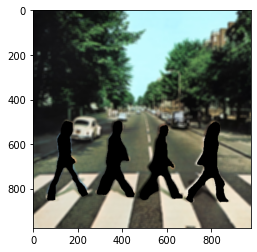

In [38]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

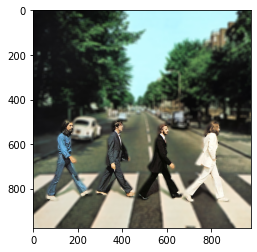

In [39]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

오... 깔끔하게 잘 된다. 그러면 사람이 아닌 동물을 human_segmentation 한다면 어떨까?
동물의 형체가 좀 이상한? 사진을 가져와서 human_segmentation 해보도록 해보자.

(720, 1280, 3)


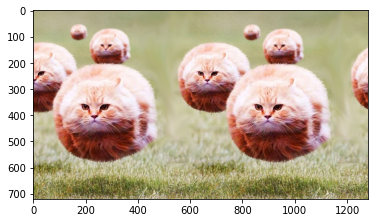

In [70]:
img_path = 'strangecat.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

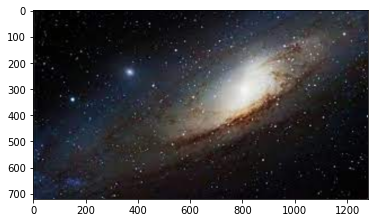

In [72]:
img_path2 = 'andromeda.jpg'  
img_bg = cv2.imread(img_path2) 

img_bg = cv2.resize(img_bg, (1280,720))
plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))
plt.show()

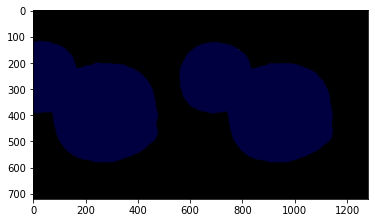

In [42]:
segvalues, output = model.segmentAsPascalvoc(img_path)
plt.imshow(output)
plt.show()

In [43]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bird
cat


In [44]:
print(colormap[3]) # bird
print(colormap[8]) # cat

[128 128   0]
[64  0  0]


In [50]:
bird_seg_color = (0,128,128) # rgb -> bgr
cat_seg_color = (0,0,64)

(720, 1280)


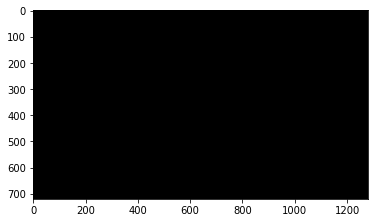

In [93]:
#bird만 출력
bird_seg_map = np.all((output==bird_seg_color), axis=-1) 
print(bird_seg_map.shape) 
plt.imshow(bird_seg_map, cmap='gray')
plt.show()

(720, 1280)


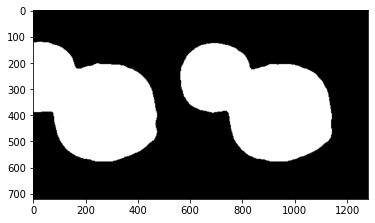

In [92]:
cat_seg_map = np.all((output==bird_seg_color) | (output == cat_seg_color), axis=-1) 
print(cat_seg_map.shape) 
plt.imshow(cat_seg_map, cmap='gray')
plt.show()

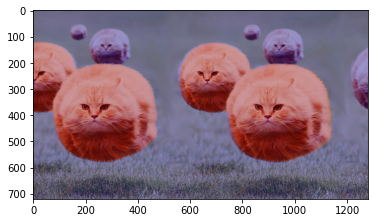

In [102]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

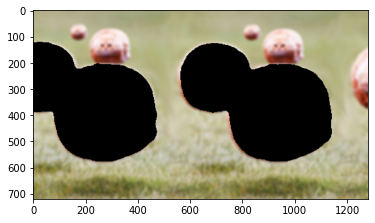

In [103]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

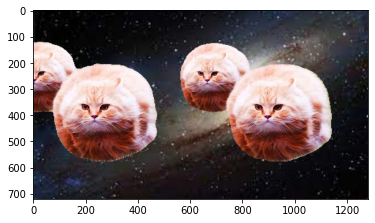

In [104]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

크로마키는 이왕 하는김에 안드로메다 배경으로 해보았다...
젤 왼쪽의 고양이처럼 얼굴의 일부분만 보여도 찾아지는 반면, 뒤에 있는 고양이들을 찾을수가 없었다.
젤 처음 비틀즈 사진에서도 뒤에 있는 car을 못찾는 것 처럼 멀리있는 사물을 못찾는 경향이 있는것 같다.